In [38]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import glob
import os
import metpy
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from datetime import datetime
import xarray as xr
from pint import UnitRegistry
ureg = UnitRegistry()
import seaborn as sns
from scipy.stats import sem
from scipy import stats
from scipy.stats import f_oneway
import statsmodels.api as sm
from scipy.stats import t

In [39]:
# Load datasets
df = pd.read_csv("C:\\YEAR1\\NMVOC\\Data\\processed_c3h8.csv", parse_dates=['datetime'])
df

,datetime,C3H8_ppb
0,2011-01-05 00:00:00,0.70974
1,2011-01-05 02:00:00,0.78550
2,2011-01-05 04:00:00,0.72628
3,2011-01-05 06:00:00,0.94738
4,2011-01-05 08:00:00,0.74331
...,...,...
41494,2023-12-31 02:00:00,0.07656
41495,2023-12-31 04:00:00,0.11815
41496,2023-12-31 05:00:00,0.10664
41497,2023-12-31 07:00:00,0.10012


In [40]:
# helper columns with  hour, month, year
#df['hour'] = df['starttime_dt'].dt.hour
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df['date'] = df['datetime'].dt.date
df['day_m'] = df['datetime'].dt.day
df['day'] = df['datetime'].dt.dayofyear
df["hour"] = df['datetime'].dt.hour
df

,datetime,C3H8_ppb,month,year,date,day_m,day,hour
0,2011-01-05 00:00:00,0.70974,1,2011,2011-01-05,5,5,0
1,2011-01-05 02:00:00,0.78550,1,2011,2011-01-05,5,5,2
2,2011-01-05 04:00:00,0.72628,1,2011,2011-01-05,5,5,4
3,2011-01-05 06:00:00,0.94738,1,2011,2011-01-05,5,5,6
4,2011-01-05 08:00:00,0.74331,1,2011,2011-01-05,5,5,8
...,...,...,...,...,...,...,...,...
41494,2023-12-31 02:00:00,0.07656,12,2023,2023-12-31,31,365,2
41495,2023-12-31 04:00:00,0.11815,12,2023,2023-12-31,31,365,4
41496,2023-12-31 05:00:00,0.10664,12,2023,2023-12-31,31,365,5
41497,2023-12-31 07:00:00,0.10012,12,2023,2023-12-31,31,365,7


In [41]:

# Ensure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# Add season (DJF, MAM, JJA, SON)

# Define season function
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['season'] = df['month'].apply(get_season)

In [ ]:
## CALCULATION nOT CONSIDERED 

# select the days with daily C3h8 average > 2σ of the seasonal mean
# https://doi.org/10.1016/j.atmosenv.2021.118245

# Group by date to get daily average
daily_avg = df.groupby('date').agg({'C3H8_ppb': 'mean'}).rename(columns={'C3H8_ppb': 'daily_avg'})
daily_avg = daily_avg.reset_index()

# Re-merge to get season and year for each day
daily_avg['year'] = daily_avg['date'].dt.year
daily_avg['month'] = daily_avg['date'].dt.month
daily_avg['season'] = daily_avg['month'].apply(get_season)

# Filter years
daily_avg = daily_avg[(daily_avg['year'] >= 2011) & (daily_avg['year'] <= 2023)]

# Compute seasonal statistics
seasonal_stats = daily_avg.groupby(['season'])['daily_avg'].agg(['mean', 'std']).reset_index()
seasonal_stats = seasonal_stats.rename(columns={'mean': 'season_mean', 'std': 'season_std'})

# Merge stats back to daily_avg
merged = pd.merge(daily_avg, seasonal_stats, on=[ 'season'], how='left')

# Identify days exceeding seasonal mean by 2σ
merged['exceeds_2sigma'] = merged['daily_avg'] > (merged['season_mean'] + 2 * merged['season_std'])

# Filter result
outliers = merged[merged['exceeds_2sigma']]

# Optional: show relevant columns
result = outliers[['date', 'year', 'season', 'daily_avg', 'season_mean', 'season_std']]
# Count occurrences per season and year (only where exceeds_2sigma is True)
count_per_season_year = merged[merged['exceeds_2sigma']].groupby(['year', 'season']).size().reset_index(name='exceeds_2sigma')
print(result)
#count_per_season_year.to_csv("C:\\YEAR1\\NMVOC\\figures\\occurr_C3h8_above_96perc.csv", index=False)

In [42]:
#Compute daily mean of c3h8_ppt from hourly data.

#Compute the 96th quantile (Q96) of those daily means, within each season.

#Count how many daily mean values exceed Q96.

#Print results grouped by year and season.

#  1. Compute daily means of c3h8_ppt
daily = df.groupby(['date', 'year', 'season'])['C3H8_ppb'].mean().reset_index()
daily.rename(columns={'C3H8_ppb': 'daily_mean'}, inplace=True)

# 2. Compute Q96 per season
q96 = daily.groupby(['season'])['daily_mean'].quantile(0.96).reset_index()
q96.rename(columns={'daily_mean': 'q96'}, inplace=True)

# 3. Merge Q96 with daily means
merged = daily.merge(q96, on=['season'], how='left')

# 4. Count exceedances
merged['above_q96'] = merged['daily_mean'] > merged['q96']
summary = merged.groupby(['year', 'season']).agg(
    q96=('q96', 'first'),
    count_above_q96=('above_q96', 'sum')
).reset_index()

# 5. Print result
print(summary.sort_values(['year', 'season']))
summary.to_csv("C:\\YEAR1\\NMVOC\\figures\\occ_month_year_96perc.csv", index=False)

    year  season       q96  count_above_q96
0   2011  Autumn  0.658053                1
1   2011  Spring  0.829945                6
2   2011  Summer  0.314260                2
3   2011  Winter  1.107487                1
4   2012  Autumn  0.658053                2
5   2012  Spring  0.829945                0
6   2012  Summer  0.314260                0
7   2012  Winter  1.107487                7
8   2013  Autumn  0.658053                7
9   2013  Spring  0.829945                0
10  2013  Summer  0.314260                5
11  2013  Winter  1.107487                4
12  2014  Autumn  0.658053                2
13  2014  Spring  0.829945                3
14  2014  Summer  0.314260                1
15  2014  Winter  1.107487                3
16  2015  Autumn  0.658053                3
17  2015  Spring  0.829945                0
18  2015  Summer  0.314260               14
19  2015  Winter  1.107487                3
20  2016  Autumn  0.658053                1
21  2016  Spring  0.829945      

In [ ]:
#Based on the code reported above: 
# 1) Compute events with consecutive daily mean concentrations above the 96th quantile of the respective seasons (4 season from 2011 to 2013) 
#2), ordinate the events from the longest (with the highest number of consecutive days) to the shortest, 
#3) print maximum daily mean value, maximum hourly mean value, 96th quantile of the seasons   

# 1. Compute daily mean concentrations
daily = df.groupby(['date', 'year', 'season'])['C3H8_ppb'].mean().reset_index()
daily.rename(columns={'C3H8_ppb': 'daily_mean'}, inplace=True)

# 2. Compute 96th percentile by season (2011–2023)
q96 = daily[(daily['year'] >= 2011) & (daily['year'] <= 2023)] \
        .groupby(['season'])['daily_mean'].quantile(0.96).reset_index()
q96.rename(columns={'daily_mean': 'q96'}, inplace=True)

# 3. Merge Q96 values with daily data
merged = daily.merge(q96, on='season', how='left')

# 4. Filter for 2011–2023 
merged = merged[(merged['year'] >= 2011) & (merged['year'] <= 2023)]

# 5. Identify exceedances
merged['above_q96'] = merged['daily_mean'] > merged['q96']

# 6. Extract only exceedance days
events_df = merged[merged['above_q96']].copy()

# 7. Identify consecutive days as events
events_df = events_df.sort_values(by='date').reset_index(drop=True)
events_df['date_diff'] = events_df['date'].diff()
events_df['gap'] = (events_df['date_diff'] != pd.Timedelta(days=1)).astype(int)
events_df['event_id'] = events_df['gap'].cumsum()

# 8. Summarize events
event_summary = events_df.groupby('event_id').agg(
    start_date=('date', 'min'),
    end_date=('date', 'max'),
    event_length=('date', 'count'),
    max_daily_mean=('daily_mean', 'max'),
    season=('season', 'first'),
    year=('year', 'first'),
    season_q96=('q96', 'first')
).reset_index()

# 9. Find max hourly mean during each event from original df
max_hourly_records = []
for _, row in event_summary.iterrows():
    mask = (df['date'] >= row['start_date']) & (df['date'] <= row['end_date'])
    event_data = df.loc[mask]
    if not event_data.empty:
        max_hourly_row = event_data.loc[event_data['C3H8_ppb'].idxmax()]
        max_hourly_records.append({
            'event_id': row['event_id'],
            'max_hourly_mean': max_hourly_row['C3H8_ppb'],
            'max_hourly_date': max_hourly_row['datetime']
        })

max_hourly_df = pd.DataFrame(max_hourly_records)

# 10. Merge back to full summary
final_events = event_summary.merge(max_hourly_df, on='event_id', how='left')

# 11. Sort from longest to shortest
final_sorted = final_events.sort_values(by='event_length', ascending=False).reset_index(drop=True)

# 12. Print results
print(final_sorted[['year', 'season', 'start_date', 'end_date', 'event_length',
                    'season_q96', 'max_daily_mean', 'max_hourly_mean', 'max_hourly_date']])
final_sorted.to_csv("C:\\YEAR1\\NMVOC\\figures\\events_above_96perc.csv", index=False)

In [ ]:
#Group consecutive days into distinct events.

#Classify each event as either single_day or multi_day.

#Count how many events fall into each category for each year and season.

# Step 1: Sort and find gaps between dates
events_df = events_df.sort_values('date').reset_index(drop=True)
events_df['date_diff'] = events_df['date'].diff()
events_df['gap'] = (events_df['date_diff'] != pd.Timedelta(days=1)).astype(int)
events_df['event_id'] = events_df['gap'].cumsum()

# Step 2: Summarize events by ID
event_summary = events_df.groupby('event_id').agg(
    event_length=('date', 'count'),
    year=('year', 'first'),
    season=('season', 'first')
).reset_index()

# Step 3: Classify events
event_summary['event_type'] = event_summary['event_length'].apply(
    lambda x: 'single_day' if x == 1 else 'multi_day'
)

# Step 4: Count occurrences by year, season, and type
event_counts = event_summary.groupby(['year', 'season', 'event_type']).size().reset_index(name='count')

# Step 5: Optional pivot table
pivot_table = event_counts.pivot_table(
    index=['year', 'season'],
    columns='event_type',
    values='count',
    fill_value=0
).reset_index()

# Step 6: Print result
print(pivot_table)
pivot_table.to_csv("C:\\YEAR1\\NMVOC\\figures\\single_mult_events_above_96perc.csv", index=False)

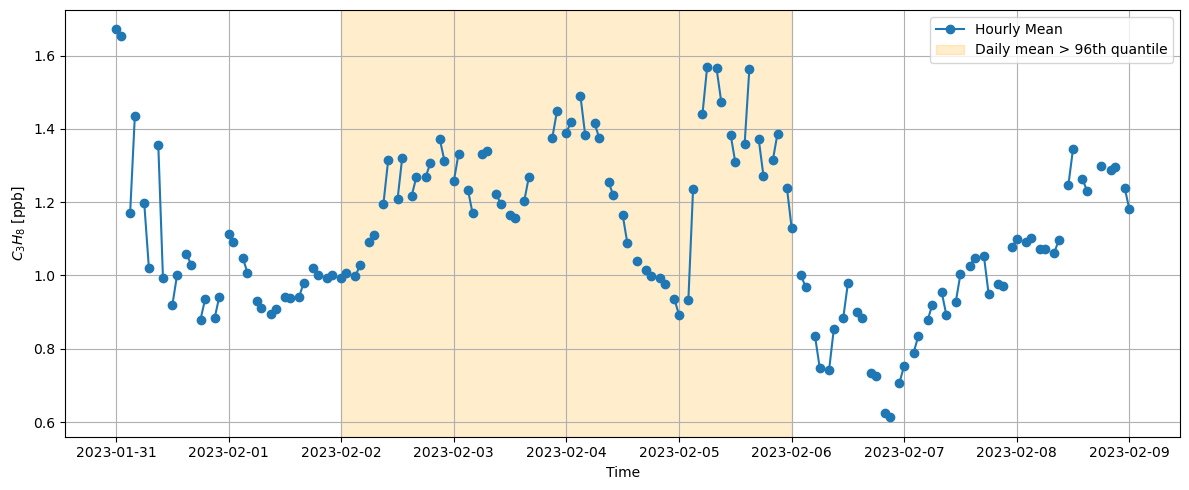

In [37]:
#plot hourly mean values between '2022-04-03'	annd '2022-04-08' (event above 96th quantile: )'2022-04-04'	annd '2022-04-07' )

# Plot hourly mean values between '2022-04-03' and '2022-04-08' (event above 96th quantile: '2022-04-04' to '2022-04-07')

# Filter the date range in the main df
mask = (df['datetime'] >= '2023-01-31') & (df['datetime'] <= '2023-02-09')
filtered = df.loc[mask].copy()

# Set datetime as index for resampling
filtered = filtered.set_index('datetime')

# Resample to hourly mean (only numeric column)
hourly_mean = filtered['C3H8_ppb'].resample('h').mean().to_frame()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(hourly_mean.index, hourly_mean['C3H8_ppb'], marker='o', linestyle='-', label='Hourly Mean')

# Highlight the event period
plt.axvspan(pd.Timestamp('2023-02-02'), pd.Timestamp('2023-02-05 23:59:59'), color='orange', alpha=0.2, label='Daily mean > 96th quantile')

#plt.title('Hourly Mean C3H8 Concentration')
plt.xlabel('Time')
plt.ylabel('$C_3H_8$ [ppb]')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("C:\\YEAR1\\NMVOC\\figures\\c3h8_high_event_feb23.png", dpi=300)
plt.show()

In [21]:
filtered 

,C3H8_ppb,month,year,date,day_m,day,hour,season
datetime,,,,,,,,


In [ ]:
#https://doi.org/10.1016/j.atmosenv.2021.118245

# Compute daily average
daily_avg = df.groupby(['date', 'year', 'season'])['C3H8_ppb'].mean().reset_index()

# Compute 96th quantile per season
thresholds = (
    daily_avg.groupby([ 'season'])['C3H8_ppb']
    .quantile(0.96)
    .reset_index()
    .rename(columns={'C3H8_ppb': 'q96'})
)

# Merge to compare
daily_avg = pd.merge(daily_avg, thresholds, on=[ 'season'], how='left')

# Filter days that exceed threshold
exceeding_days = daily_avg[daily_avg['C3H8_ppb'] > daily_avg['q96']]

# Now filter for June & July 2023
exceeding_days['month'] = pd.to_datetime(exceeding_days['date']).dt.month
mask = (exceeding_days['year'] == 2023) & (exceeding_days['month'].isin([6, 7]))
june_july_exceeding_2023 = exceeding_days[mask]

# Print result
print("Days in June & July 2023 exceeding the 96th percentile (by  season):\n")
print(june_july_exceeding_2023[['date', 'C3H8_ppb', 'q96', 'season']])

